Analysis of two-port RC data

VNA -> patch pannel -> antennas. Calibration plane is right before the antenna. Uses calibration file SOLT250M-1050M4501pt_4_14_25.cal (except High res which uses SOLT300M-320M4001pt_4_11_25.cal. This calibration may be bad). Big vivaldi is port 2. log periodic is port 1. 

The stirrer has 4800 steps per 360 degrees. This comes from 400 steps/rotation of the stepper motor, 4x microsteps, and a 3:1 gear ratio. 400 $\times$ 4 $\times$ 3 = 4800 steps/rev. We have invested a week in calibration using this number of microsteps, so it is hard coded and will likley never change

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

# Plotting format 
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

directory = './data_gitignore/'

In [276]:
# Load the DataFrame from CSV
if 0: # high resolution = 5kHz. 300-320MHz span, 4000 frequency points. 
    # stirPos 1272 and 1896 dropped some frequency points! 
    df_HR   = pd.read_csv(directory 
        + "2portRcTest_300MHz_4_14_25_200Steps.csv")
    df_HR[["S11", "S12", "S22"]] = df_HR[["S11", "S12", "S22"]].astype(complex)       

if 1: # 177.8kHz resolution (sorry), 250-1050MHz, 4500 frequency points
    df      = pd.read_csv(directory 
        + "2portRcTest_250_1050MHz_200steps_4_14_25.csv")
    df[["S11", "S12", "S22"]] = df[["S11", "S12", "S22"]].astype(complex)  

    df_cp   = pd.read_csv(directory 
        + "2portRcTest_250_1050MHz_200steps_crossPolarizeVivaldi_4_14_25.csv")   # same as above, but vivaldi is cross polarized (by eye)
    df_cp[["S11", "S12", "S22"]] = df_cp[["S11", "S12", "S22"]].astype(complex)

    df_couple   = pd.read_csv(directory 
        + "antennaFacingEachOther_200Step_5secDwell_250_1050MHz_4501freq_2p5kHzRBW_avg1_4_16_25.csv")   # same setings as above, but antennas are coupled by facing each other. 50cm apart polarization matched
    df_couple[["S11", "S12", "S22"]] = df_couple[["S11", "S12", "S22"]].astype(complex)



if 0: # reprroducibility test. Same settings, taken one after another. 10 steps, 250-1050MHz
    df_rep1      = pd.read_csv(directory 
        + "10StepReproducibility_v1_10secDwell_4_15_25.csv")  
    df_rep1[["S11", "S12", "S22"]] = df_rep1[["S11", "S12", "S22"]].astype(complex)
    df_rep2      = pd.read_csv(directory 
        + "10StepReproducibility_v2_10secDwell_4_15_25.csv")  
    df_rep2[["S11", "S12", "S22"]] = df_rep2[["S11", "S12", "S22"]].astype(complex)
    df_rep3      = pd.read_csv(directory 
        + "10StepReproducibility_v3_10secDwell_4_15_25.csv")  
    df_rep3[["S11", "S12", "S22"]] = df_rep3[["S11", "S12", "S22"]].astype(complex)
if 0: # reprroducibility test. Same settings, taken one after another. 5 sec dwell 10 steps, 250-1050MHz
    df_rep4      = pd.read_csv(directory 
        + "10StepReproducibility_v4_5secDwell_4_16_25.csv")  
    df_rep4[["S11", "S12", "S22"]] = df_rep4[["S11", "S12", "S22"]].astype(complex)
    df_rep5      = pd.read_csv(directory 
        + "10StepReproducibility_v5_5secDwell_4_16_25.csv")  
    df_rep5[["S11", "S12", "S22"]] = df_rep5[["S11", "S12", "S22"]].astype(complex)
if 0: # 600 steps  Same settings as above. Same ant pos as rep4 and rep 5. 5 sec dwell 250-1050MHz
    df_600Steps      = pd.read_csv(directory 
        + "600Step_5secDwell_250_1050MHz_4501freq_2p5kHzRBW_avg1_4_16_25.csv")  
    df_600Steps[["S11", "S12", "S22"]] = df_600Steps[["S11", "S12", "S22"]].astype(complex)


print(df_couple.head())
#print(df_rep2.head())

   stirPos    Freq_MHz                 S11                 S12  \
0        0  250.000000  0.532774-0.350030j  0.216402-0.023878j   
1        0  250.177777  0.448733-0.380339j  0.236118-0.124533j   
2        0  250.355555  0.402973-0.326899j  0.188476-0.218701j   
3        0  250.533333  0.419365-0.269314j  0.103244-0.268641j   
4        0  250.711111  0.460512-0.245815j  0.023530-0.271644j   

                  S22  
0  0.339106-0.666515j  
1  0.323203-0.605366j  
2  0.343841-0.562922j  
3  0.374631-0.555551j  
4  0.377214-0.570338j  


In [277]:
# The VNA sometimes drops frequency points. Not that big of an issue, but should know about it. 
# check how many freq points.

dfName = df_couple

for stirPos, group in dfName.groupby("stirPos"):
    freq_array = group["Freq_MHz"].values  # Get the frequency array as a numpy array
    if len(freq_array) != 4501:
        print(f"ERROR!!! stirPos {stirPos}: {len(freq_array)} frequency points at stirPos = {stirPos}")
    #print(f"stirPos {stirPos}: {len(freq_array)} frequency points")
    

In [4]:
#functions

def get_s_at_frequency(target_freq, df, s_parameter, printFreq = True):
    """
    Extracts and returns an array of S-parameter values (complex) from the DataFrame at the frequency
    closest to the given target_freq.
    Prints the actual frequency used. 
    
    Parameters:
      target_freq (float): The target frequency (in MHz) for which S-parameter values are needed.
      df (pd.DataFrame): The DataFrame containing the data. This DataFrame is expected to
                         have columns "Sweep time", "Freq_MHz", "S12", "S11", and "S22".
        s_parameter (string): s-parameter to be extracted. accepts S11, S22 or S12. 
                         
    Returns:
      stirPos (np.ndarray): array of stirrer position in units of steps from zero
      S_parameter (np.ndarray): Array of S-parameter values (complex) corresponding to the frequency closest to target_freq,
                  one per unique "Sweep time" in the DataFrame.
    """
    s_values = []
    
    # Group the dataframe by "Sweep time", so that each group represents a separate sweep.
    groups = df.groupby("stirPos")
    # For each sweep, find the row where Freq_MHz is closest to target_freq.
    for sweep_time, group in groups:
        # Calculate the absolute difference between the frequencies and target_freq.
        diff = (group["Freq_MHz"] - target_freq).abs()
        # Get the index of the smallest difference.
        closest_index = diff.idxmin()
        # Extract the S12 value at that index.
        s_val = group.loc[closest_index, s_parameter]
        # Ensure the value is a complex number (if it's a string, convert it).
        if isinstance(s_val, str):
            s_val = complex(s_val)
        s_values.append(s_val)
    if printFreq == True:
        print("Closest frequency:", group.loc[closest_index, "Freq_MHz"], "MHz")
    return pd.unique(df['stirPos']), np.array(s_values)



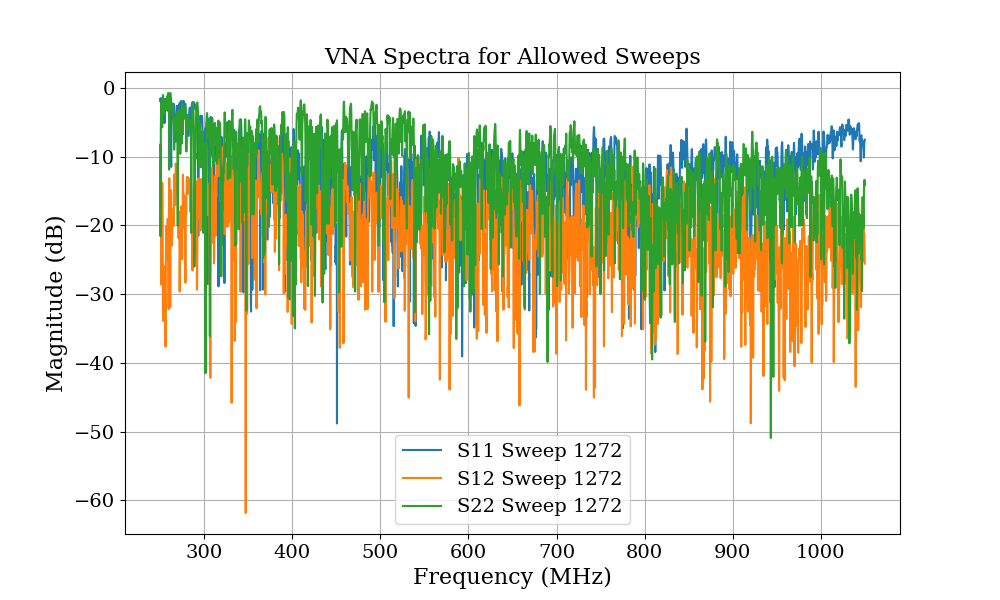

In [149]:
#general plotting of S vs freq for a given list of positions

# Specify the list of sweeps you want to plot.
posArr = [1272]

# Create a new figure.
plt.figure(figsize=(10, 6))

# Group the data by sweep number and plot only the selected sweeps.
for sweep, group in df.groupby("stirPos"):
    if sweep not in posArr:
        continue  # Skip sweeps that are not in the allowed list
    freqs = group["Freq_MHz"]    
    plt.plot(freqs, 20*np.log10(np.abs(group["S11"])), label=f"S11 Sweep {sweep}")
    plt.plot(freqs, 20*np.log10(np.abs(group["S12"])), label=f"S12 Sweep {sweep}")
    plt.plot(freqs, 20*np.log10(np.abs(group["S22"])), label=f"S22 Sweep {sweep}")

# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps")
plt.legend()
plt.grid(True)
plt.show()

Closest frequency: 1050.0 MHz
Closest frequency: 1050.0 MHz
Closest frequency: 1050.0 MHz
Closest frequency: 1050.0 MHz
Closest frequency: 1050.0 MHz
Closest frequency: 1050.0 MHz


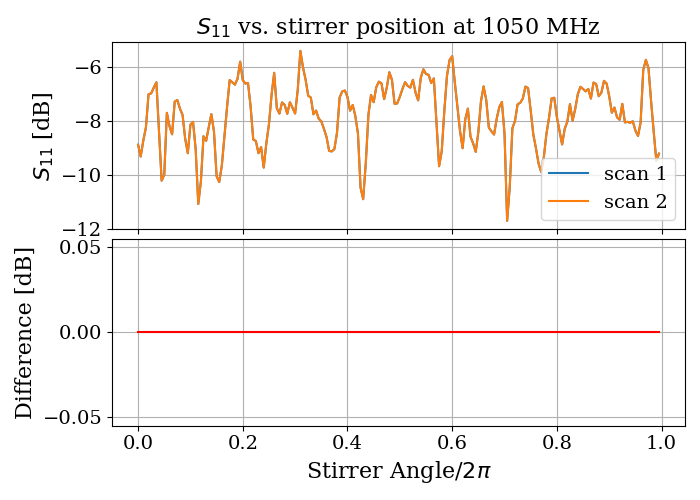

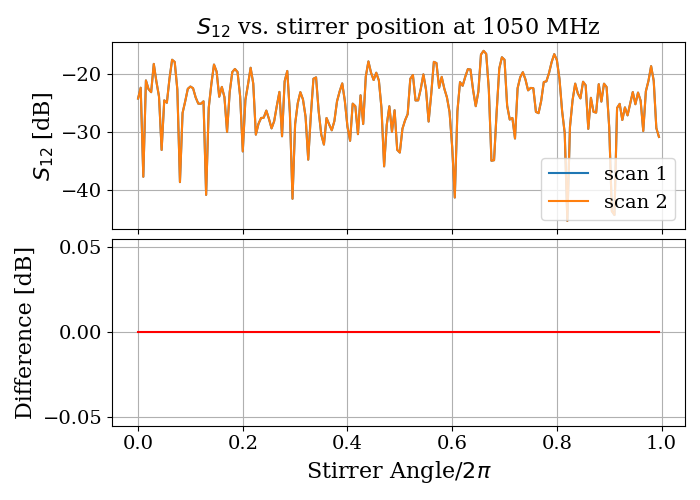

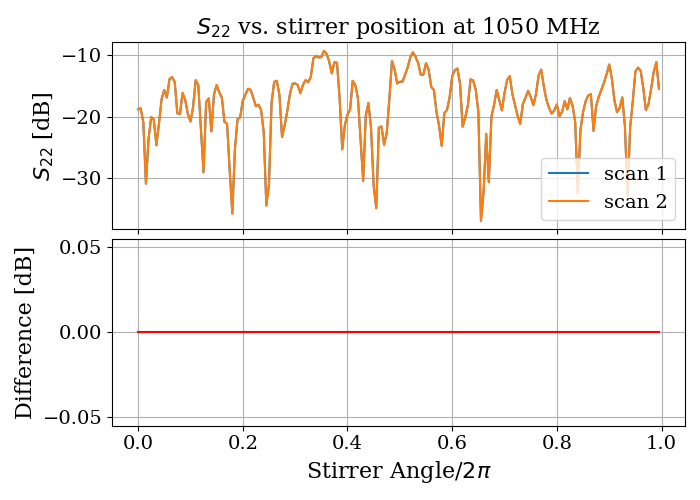

In [45]:
# Are positions reproducible? 
#In this cell, we compare the high res (300-320MHz) and low res (250-1050MHz) scan. These should be the same. 
freq = 1050 # note, different resolutions. 301.2, 304.4, 306 ..., 318.8 MHz show up exactly in both resolutions
                # 301.2 is bad!!!!! stirPos = 1278 and 1896 drop the first few hundred frequency points in the high res. VNA error
#choose dfs 10 use
df1 = df
df2 = df
df1Name = 'scan 1'
df2Name = 'scan 2'

#extract S parameters
#S11
posArr, S11_1  = get_s_at_frequency(freq, df1, "S11")
posArr, S11_2      = get_s_at_frequency(freq, df2, "S11")
#S12
posArr, S12_1  = get_s_at_frequency(freq, df1, "S12")
posArr, S12_2     = get_s_at_frequency(freq, df2, "S12")
#S22
posArr, S22_1  = get_s_at_frequency(freq, df1, "S22")
posArr, S22_2     = get_s_at_frequency(freq, df2, "S22")

plt.close('all')

#plot s11
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S11 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11_1)), label=df1Name)
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11_2)), label=df2Name)
axs[0].set_title(f'$S_{{11}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{11}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S11_1)) - 20*np.log10(np.abs(S11_2))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)
plt.tight_layout()

plt.subplots_adjust(hspace=0.05)
plt.show()


#plot s12
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S12 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12_1)), label=df1Name)
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12_2)), label=df2Name)
axs[0].set_title(f'$S_{{12}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{12}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S12_1)) - 20*np.log10(np.abs(S12_2))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)
plt.tight_layout()

plt.subplots_adjust(hspace=0.05)
plt.show()

#plot s22
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S22 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22_1)), label=df1Name)
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22_2)), label=df2Name)
axs[0].set_title(f'$S_{{22}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{22}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S22_1)) - 20*np.log10(np.abs(S22_2))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)
plt.tight_layout()

plt.subplots_adjust(hspace=0.05)
plt.show()

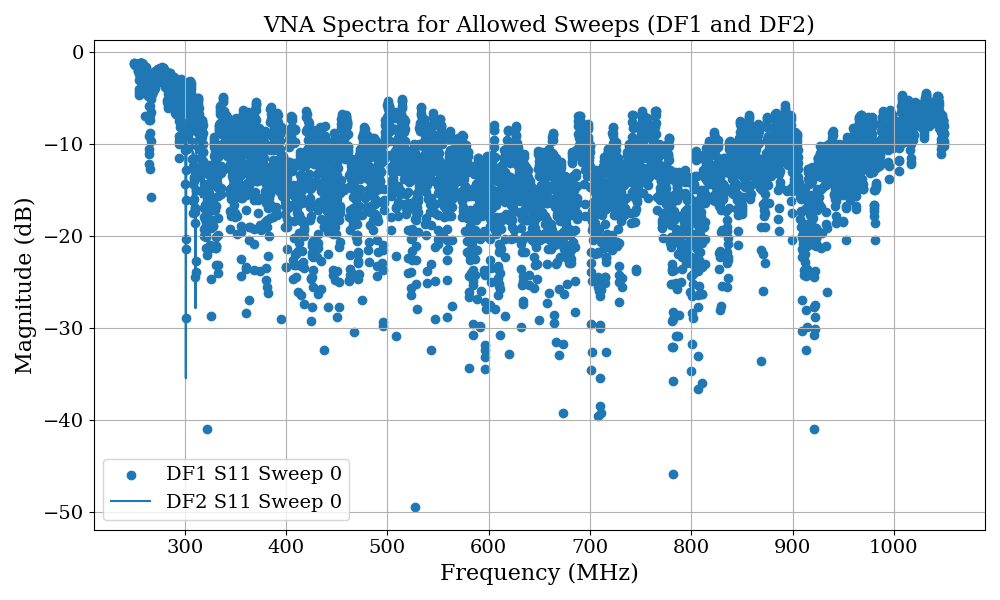

In [72]:
#Compare resolutions

import matplotlib.pyplot as plt
import numpy as np

# Specify the list of sweeps you want to plot.
allowed_sweeps = [0]

plt.figure(figsize=(10, 6))

# Plot data from df1.
for sweep, group in df.groupby("stirPos"):
    if sweep not in allowed_sweeps:
        continue  # skip sweeps not in the allowed list
    freqs = group["Freq_MHz"]
    s11_complex = group["S11"].apply(lambda x: complex(x) if isinstance(x, str) else x)
    s11_db = 20 * np.log10(np.abs(s11_complex))
    plt.scatter(freqs, s11_db, label=f"DF1 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='-', label=f"DF1 S22 Sweep {sweep}")

# Plot data from high res.
for sweep, group in df_HR.groupby("stirPos"):
    if sweep not in allowed_sweeps:
        continue
    freqs = group["Freq_MHz"]
    s11_complex = group["S11"].apply(lambda x: complex(x) if isinstance(x, str) else x)
    s11_db = 20 * np.log10(np.abs(s11_complex))
    plt.plot(freqs, s11_db, label=f"DF2 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='--', label=f"DF2 S22 Sweep {sweep}")

plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps (DF1 and DF2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The following few cells perform some testing to compute the number of independent positions

Closest frequency: 299.955555 MHz
Closest frequency: 600.044444 MHz
Closest frequency: 800.044444 MHz
Closest frequency: 1000.044444 MHz


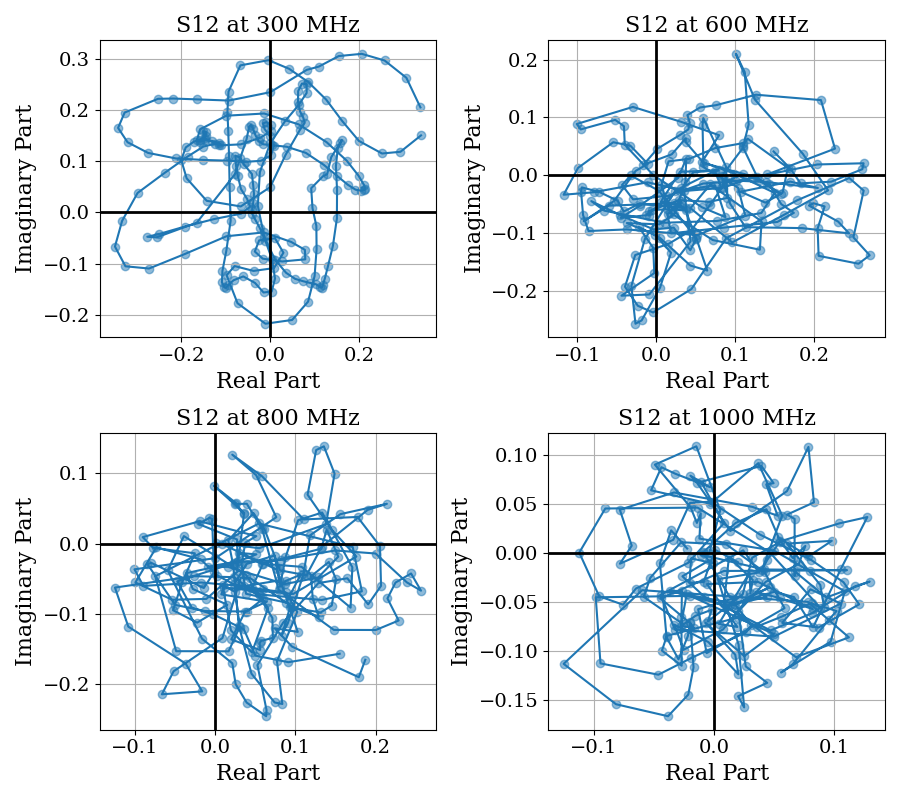

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the list of target frequencies (in MHz).
target_freqs = [300, 600, 800, 1000]

# Prepare a list to hold the S12 arrays.
s12_arrays = []

# Get S12 data for each frequency.
for f in target_freqs:
    none, s12_array = get_s_at_frequency(f, df, "S12")
    s12_array = s12_array[::]
    s12_arrays.append(s12_array)

# Create a 2x2 grid of subplots.
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = axs.flatten()  # Flatten to a single list for easier iteration.

# Loop over the target frequencies and corresponding S12 arrays.
for i, f in enumerate(target_freqs):
    s12_arr = s12_arrays[i]
    axs[i].plot(np.real(s12_arr), np.imag(s12_arr))
    axs[i].scatter(np.real(s12_arr), np.imag(s12_arr), alpha = .5)
    axs[i].set_xlabel("Real Part")
    axs[i].set_ylabel("Imaginary Part")
    axs[i].set_title(f"S12 at {f} MHz")
    axs[i].grid(True)
    # Add bold lines at the origin (0,0)
    axs[i].axhline(y=0, color='black', linewidth=2)
    axs[i].axvline(x=0, color='black', linewidth=2)
    

plt.tight_layout()
plt.show()


Closest frequency: 918.088888 MHz


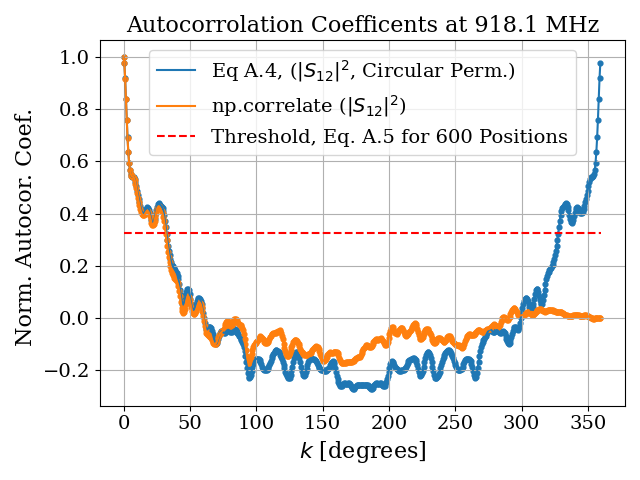

In [284]:
def tuner_efficiency_autocorr(S12):
    """
    Implements IEC 61000-4-21 Annex A.3 (Equation A.4) for
    tuner efficiency/autocorrelation at a single frequency.

    Parameters
    ----------
    S12 : np.ndarray
        1D array (length N) of complex S12 measurements,
        one value per stirrer position. 

    Returns
    -------
    r_array : np.ndarray
        1D array (length N) of correlation coefficients r(k),
        for circular shifts k = 0, 1, ..., N-1.
        r_array[0] should be 1.0 (perfect correlation at zero shift).
    """
    # 1) Convert to power-like data: x[i] = |S12[i]|^2
    x = np.abs(S12)
    N = len(x)
    #x_mean = x.mean()
    #x_zeromean = x - x_mean
    
    # 2) Precompute the mean and denominator portion for x
    ux = np.mean(x)
    sum_sq_x = np.sum((x - ux)**2)
    
    # Prepare output
    r_array = np.zeros(N, dtype=float)
    
    # 3) Loop over all possible shifts k
    for k in range(N):
        # Circularly shift x by k steps
        y = np.roll(x, -k)  # negative sign just a convention; either way is fine
        uy = np.mean(y)
        
        # Numerator: sum over i of (x_i - u_x)*(y_i - u_y)
        numerator = np.sum((x - ux) * (y - uy))
        
        # Denominator: sqrt( sum((x-ux)^2) * sum((y-uy)^2) )
        # But note y is just x shifted, so sum((y-uy)^2) = sum((x-ux)^2).
        sum_sq_y = np.sum((y - uy)**2)
        denom = np.sqrt(sum_sq_x * sum_sq_y)
        
        # Avoid division by zero if data is degenerate
        if denom == 0:
            r_array[k] = 0.0
        else:
            r_array[k] = numerator / denom
    
    return r_array


freq = 918.1#783.3#427.7 #[MHz]
df_indPos = df_600Steps
stirPosArr, S12 = get_s_at_frequency(freq, df_indPos, "S12")
r_thresh = 0.37 * (1 - (7.22/len(S12)**0.64)) #EMC 4-21, Eq. A.5

x = (np.abs(S12)**2)- np.mean(np.abs(S12)**2)
raw_corr = np.correlate(x,x, mode="full")[int((len(stirPosArr)-1)):len(stirPosArr)*2]/np.sum(x**2)#75.3

plt.close('all')

if 0:
    plt.figure()
    plt.plot(tuner_efficiency_autocorr(S12), label = 'eq A.4')
    plt.plot(tuner_efficiency_autocorr(np.abs(S12)**2), label = 'eq A.4, S12^2')
    plt.plot(tuner_efficiency_autocorr((np.abs(S12))- np.mean(np.abs(S12))), label = 'eq A.4, S12, zero mean')
    plt.plot(tuner_efficiency_autocorr((np.abs(S12)**2)- np.mean(np.abs(S12)**2)), label = 'eq A.4, S12^2, zero mean')
    #plt.plot(tuner_efficiency_autocorr(np.random.normal(0,1,200)))
    #x = abs(S12)**2
    #plt.plot(autocorr_coeff(x))
    plt.hlines(r, 0, len(stirPosArr), 'r')
    plt.grid()
    plt.legend()



plt.figure()
plt.title(f'Autocorrolation Coefficents at {freq} MHz')
plt.plot(stirPosArr/4800*360, tuner_efficiency_autocorr((np.abs(S12)**2)), label = r'Eq A.4, ($|S_{12}|^2$, Circular Perm.)')
plt.plot(stirPosArr/4800*360, raw_corr, label = r'np.correlate ($|S_{12}|^2$)')
plt.scatter(stirPosArr/4800*360, tuner_efficiency_autocorr((np.abs(S12)**2)), s = 12)
plt.scatter(stirPosArr/4800*360, raw_corr, s = 12)
#plt.plot(tuner_efficiency_autocorr(np.random.normal(0,1,200)))
#x = abs(S12)**2
#plt.plot(autocorr_coeff(x))
plt.hlines(r_thresh, 0, 360, 'r', linestyles='--', label= f'Threshold, Eq. A.5 for {len(stirPosArr)} Positions')
plt.grid()
plt.xlabel(r"$k$ [degrees]")
plt.ylabel("Norm. Autocor. Coef. ")
plt.legend()
plt.tight_layout()

In [263]:
if 0:
    freqs = pd.unique(df["Freq_MHz"])
    r_thresh = 0.37 * (1 - (7.22/len(S12)**0.64))
    numPos = []
    freqSkip = 1 #takes a while if you plot all the freqs

    for freq in freqs[::freqSkip]:
        print(freq)
        stirPosArr, S12 = get_s_at_frequency(freq, df_indPos, "S12", printFreq=False)
        rArr = tuner_efficiency_autocorr(np.abs(S12)**2)

        #mask = rArr < r                 # True where correlation drops below threshold
        #k    = mask.argmax() if mask.any() else len(rArr)   # first crossing (or N if none)
        #print(k)
        #numPos.append(k)
        
        numPos.append(np.where(rArr < r_thresh)[0][0])
        
        #print(np.where(rArr < r)[0][0])
        #k = np.where(rArr < r)[0][0]                            # first crossing
        #numPos.append((k-1 + (r - rArr[k-1])/(rArr[k] - rArr[k-1])))


250.0
250.177777
250.355555
250.533333
250.711111
250.888888
251.066666
251.244444
251.422222
251.6
251.777777
251.955555
252.133333
252.311111
252.488888
252.666666
252.844444
253.022222
253.2
253.377777
253.555555
253.733333
253.911111
254.088888
254.266666
254.444444
254.622222
254.8
254.977777
255.155555
255.333333
255.511111
255.688888
255.866666
256.044444
256.222222
256.4
256.577777
256.755555
256.933333
257.111111
257.288888
257.466666
257.644444
257.822222
258.0
258.177777
258.355555
258.533333
258.711111
258.888888
259.066666
259.244444
259.422222
259.6
259.777777
259.955555
260.133333
260.311111
260.488888
260.666666
260.844444
261.022222
261.2
261.377777
261.555555
261.733333
261.911111
262.088888
262.266666
262.444444
262.622222
262.8
262.977777
263.155555
263.333333
263.511111
263.688888
263.866666
264.044444
264.222222
264.4
264.577777
264.755555
264.933333
265.111111
265.288888
265.466666
265.644444
265.822222
266.0
266.177777
266.355555
266.533333
266.711111
266.888888

Text(0.5, 0, 'Frequency [MHz]')

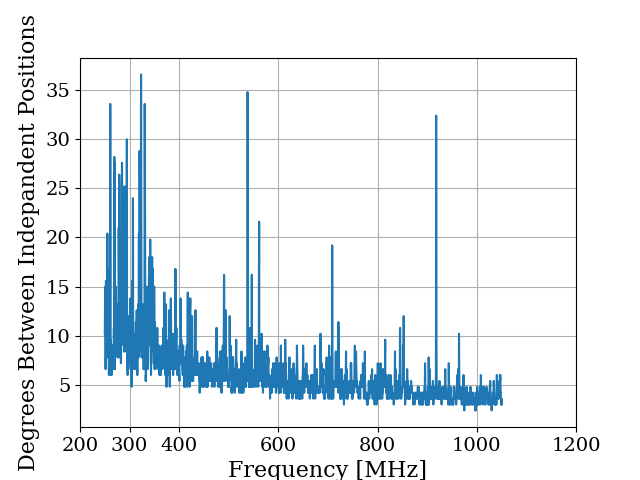

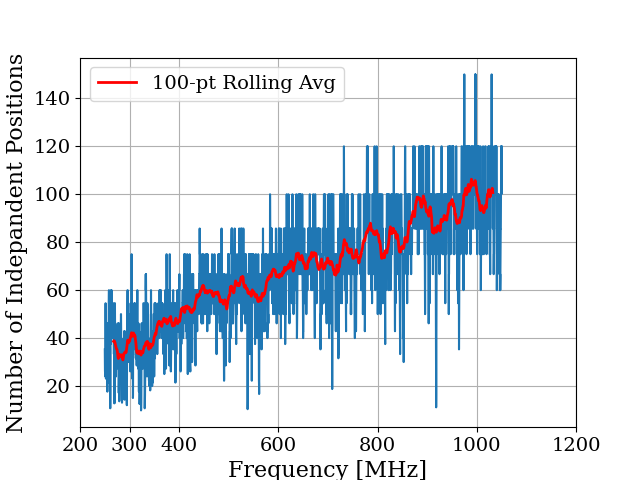

In [283]:
numPos = np.asarray(numPos)
plt.figure()
plt.plot(freqs[::freqSkip], numPos/600*360)
plt.grid()
plt.gca().set_xticks(list(plt.gca().get_xticks()) + [300])
#plt.xlim(270, 1050)
plt.ylabel('Degrees Between Indepandent Positions')
plt.xlabel('Frequency [MHz]')

avgBinLen = 100
plt.figure()
plt.plot(freqs[::freqSkip], 360/(numPos/600*360))
avg = np.convolve(600/numPos, np.ones(avgBinLen)/avgBinLen, mode='same')
plt.plot(freqs[avgBinLen:-avgBinLen:freqSkip], avg[avgBinLen:-avgBinLen], 'r-', lw=2, label=f'{avgBinLen}‑pt Rolling Avg')


plt.legend()
plt.grid()
plt.gca().set_xticks(list(plt.gca().get_xticks()) + [300])
#plt.xlim(270, 1050)
plt.ylabel('Number of Indepandent Positions')
plt.xlabel('Frequency [MHz]')

Now we have the number of independent stir positions. Next we start to compute ensamble averages.

In [254]:
def bootstrap_ensemble_mean(df, num_samples):
    """
    Draws `num_samples` stirPos values (with replacement) and computes the ensemble‐average
    S11, S12 and S22 at each frequency.
    
    Parameters:
      df (pd.DataFrame): must have columns ['stirPos','Freq_MHz','S11','S12','S22'] (S-params as complex dtype).
      num_samples (int): number of stirPos to draw with replacement.
    
    Returns:
      pd.DataFrame: indexed by Freq_MHz, with columns ['S11','S12','S22'] giving the averaged complex values.
    """
    # 1) collapse to one row per (stirPos,Freq_MHz) in case there are duplicates
    df_pos = df.groupby(['stirPos','Freq_MHz'])[['S11','S12','S22']].mean().reset_index()
    
    # 2) sample stirPos values with replacement
    unique_positions = df_pos['stirPos'].unique()
    draws = np.random.choice(unique_positions, size=num_samples, replace=True)
    
    # 3) replicate rows for each draw
    draws_df = pd.DataFrame({'stirPos': draws})
    sampled = draws_df.merge(df_pos, on='stirPos')
    
    # 4) group by frequency and average
    result = sampled.groupby('Freq_MHz')[['S11','S12','S22']].mean()
    return result

def ensamble_mean_all(df):
  mean_S = df.groupby("Freq_MHz")[["S11","S12","S22"]].mean()
  return mean_S

def rician_k(df, s_parameter):
    """
    Compute the Rician K‐factor per frequency:
      K(f) = |⟨S(f)⟩|²  /  ⟨ |S(f) − ⟨S(f)⟩|² ⟩
    
    where ⟨⋅⟩ is the average over all stirPos at that freq.
    
    Returns a pandas Series indexed by Freq_MHz.
    """
    return (
        df
        .groupby("Freq_MHz")[s_parameter]
        .apply(lambda x: 
            (np.abs(x.mean())**2) 
            / ((np.abs(x - x.mean())**2).mean())
        )
    )


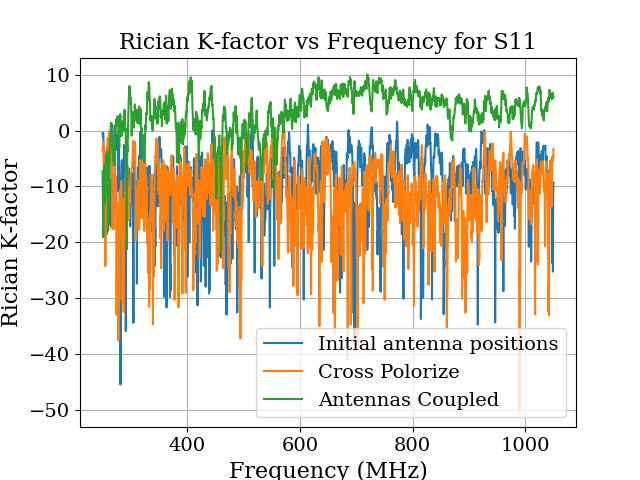

In [288]:
plt.close('all')
K_S11 = rician_k(df, "S12")
K_couple_S11 = rician_k(df_couple, "S12")
K_cp_S11 = rician_k(df_cp, "S12")

plt.figure()
plt.plot(K_S11.index, 10*np.log10(K_S11.values), label = 'Initial antenna positions')
plt.plot(K_cp_S11.index, 10*np.log10(K_cp_S11.values), label = 'Cross Polorize')
plt.plot(K_couple_S11.index, 10*np.log10(K_couple_S11.values), label = 'Antennas Coupled')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Rician K‑factor")
plt.title("Rician K‑factor vs Frequency for S11")
plt.grid(True)
plt.legend()
plt.show()


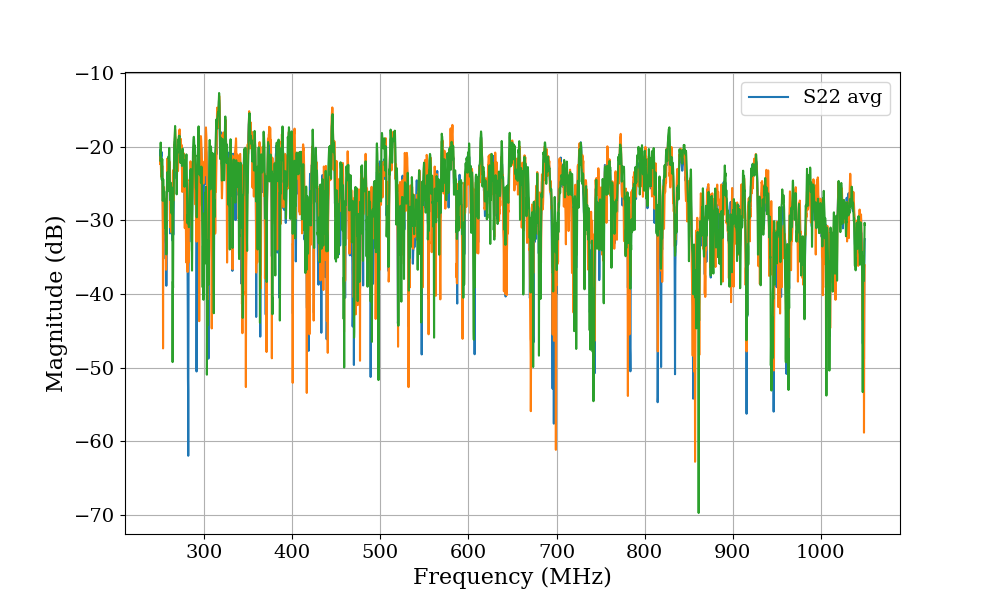

In [289]:
#general plotting of S vs freq for a given list of positions

# Specify the list of sweeps you want to plot.
posArr = [0, 240, 4800-24]

# Create a new figure.
plt.figure(figsize=(10, 6))

# Group the data by sweep number and plot only the selected sweeps.
for sweep, group in df.groupby("stirPos"):
    if sweep not in posArr:
        continue  # Skip sweeps that are not in the allowed list
    freqs = group["Freq_MHz"]    
    #plt.plot(freqs, 20*np.log10(np.abs(group["S11"])), label=f"S11 Sweep {sweep}")
    #plt.plot(freqs, 20*np.log10(np.abs(group["S12"])), label=f"S12 Sweep {sweep}")
    #plt.plot(freqs, 20*np.log10(np.abs(group["S22"])), label=f"S22 Sweep {sweep}")

df_avgAll = ensamble_mean_all(df)
df_boot1 = bootstrap_ensemble_mean(df, 30)
df_boot2 = bootstrap_ensemble_mean(df, 30)

plt.plot(freqs, 20*np.log10(np.abs(df_avgAll["S12"])), label=f"S22 avg")
plt.plot(freqs, 20*np.log10(np.abs(df_boot1["S12"])))#, label=f" avg")
plt.plot(freqs, 20*np.log10(np.abs(df_boot2["S12"])))#, label=f"S22 avg")
# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.show()

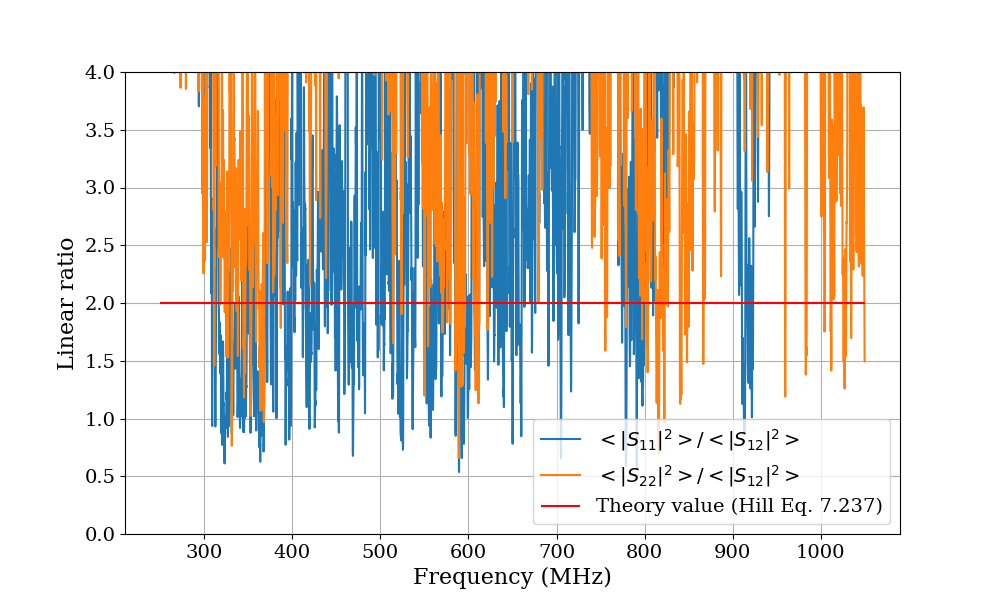

In [310]:
#Hill book fig. 7.23


# Create a new figure.
plt.figure(figsize=(10, 6))
df1 = df_rep1

mean_power_S11 = df1.groupby("Freq_MHz")["S11"] \
                  .apply(lambda x: (np.abs(x)**2).mean())

mean_power_S12 = df1.groupby("Freq_MHz")["S12"] \
                  .apply(lambda x: (np.abs(x)**2).mean())

mean_power_S22 = df1.groupby("Freq_MHz")["S22"] \
                  .apply(lambda x: (np.abs(x)**2).mean())
                  




plt.plot(freqs, mean_power_S11/mean_power_S12, label = r'$<|S_{11}|^2>/<|S_{12}|^2>$')
plt.plot(freqs, mean_power_S22/mean_power_S12, label = r'$<|S_{22}|^2>/<|S_{12}|^2>$')
plt.hlines(2, 250,1050, 'r',label= 'Theory value (Hill Eq. 7.237)')
# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Linear ratio")
plt.legend()
plt.ylim(0, 4)
plt.grid(True)
plt.show()



In [326]:
# Test simple DataFrame with 3 stir positions and 3 frequencies, 9 rows total
df_test = pd.DataFrame({
    "stirPos":   [1, 1, 1,  2, 2, 2,  3, 3, 3],
    "Freq_MHz":  [1, 2, 3,  1, 2, 3,  1, 2, 3],
    "S11":       list(range(1, 10)),    # 1, 2, …, 9
    "S12":       list(range(10, 19)),   # 10, 11, …, 18
    "S22":       list(range(19, 28)),   # 19, 20, …, 27
})

print(df_test)
mean_power_S11 = df_test.groupby("Freq_MHz")["S11"] \
                    .apply(lambda x: (np.abs(x)**2).mean())
print(mean_power_S11)
if 0:
    mean_power_S11 = df_test.groupby("Freq_MHz")["S11"] \
                    .apply(lambda x: (np.abs(x)**2).mean())
    mean_power_S12 = df_test.groupby("Freq_MHz")["S12"] \
                    .apply(lambda x: (np.abs(x)**2).mean())
    mean_power_S22 = df_test.groupby("Freq_MHz")["S22"] \
                    .apply(lambda x: (np.abs(x)**2).mean())
    print('######## S11 ########')
    print(mean_power_S11)
    print('Manual calc for freq 1: ', np.mean([1**2, 4**2, 7**2]))
    print('Manual calc for freq 2: ', np.mean([2**2, 5**2, 8**2]))
    print('Manual calc for freq 3: ', np.mean([3**2, 6**2, 9**2]))

    print('######## S12 ########')
    print(mean_power_S12)
    print('Manual calc for freq 1: ', np.mean([10**2, 13**2, 16**2]))
    print('Manual calc for freq 2: ', np.mean([11**2, 14**2, 17**2]))
    print('Manual calc for freq 3: ', np.mean([12**2, 15**2, 18**2]))

    print('######## S22 ########')
    print(mean_power_S22)
    print('Manual calc for freq 1: ', np.mean([19**2, 22**2, 25**2]))
    print('Manual calc for freq 2: ', np.mean([20**2, 23**2, 26**2]))
    print('Manual calc for freq 3: ', np.mean([21**2, 24**2, 27**2]))

   stirPos  Freq_MHz  S11  S12  S22
0        1         1    1   10   19
1        1         2    2   11   20
2        1         3    3   12   21
3        2         1    4   13   22
4        2         2    5   14   23
5        2         3    6   15   24
6        3         1    7   16   25
7        3         2    8   17   26
8        3         3    9   18   27
Freq_MHz
1    22.0
2    31.0
3    42.0
Name: S11, dtype: float64


/tmp/ipykernel_2043171/4270936086.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 6))


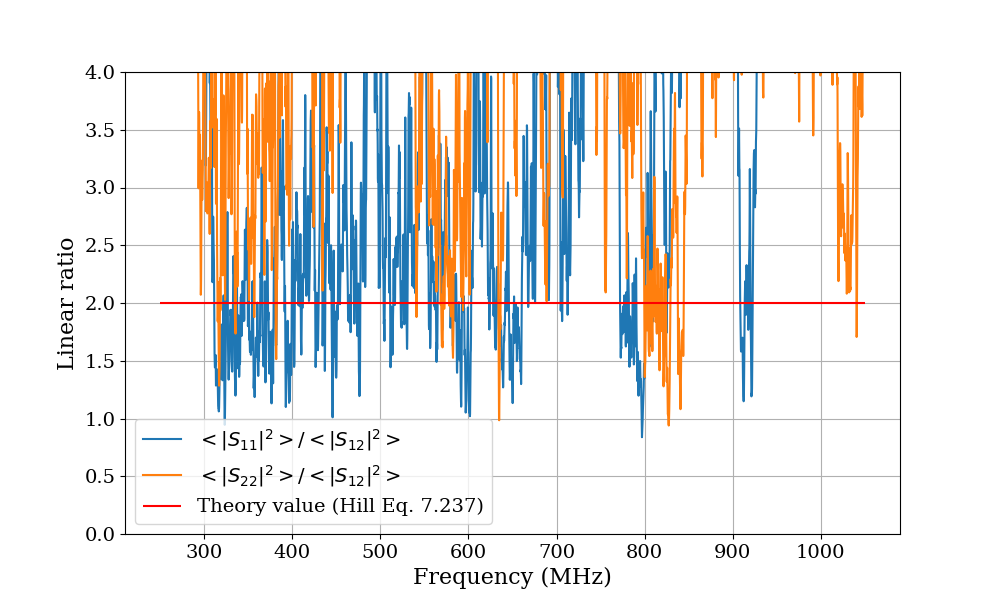

In [308]:
#Hill book fig. 7.23


# Create a new figure.
plt.figure(figsize=(10, 6))
df1 = df

mean_power_S12 = df1.groupby("Freq_MHz")["S12"] \
                  .apply(lambda x: (np.abs(x)**2).mean())

mean_power_S22 = df1.groupby("Freq_MHz")["S22"] \
                  .apply(lambda x: (np.abs(x)**2).mean())
                  



plt.close('all')
plt.plot(freqs, mean_power_S11/mean_power_S12, label = r'$<|S_{11}|^2>/<|S_{12}|^2>$')
plt.plot(freqs, mean_power_S22/mean_power_S12, label = r'$<|S_{22}|^2>/<|S_{12}|^2>$')
plt.hlines(2, 250,1050, 'r',label= 'Theory value (Hill Eq. 7.237)')
# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Linear ratio")
plt.legend()
plt.ylim(0, 4)
plt.grid(True)
plt.show()

